---
<div align="center">

# ML2 | Urban Sound Classification
</div>

---

---
## Problem Formulation
---

> ADD PROBLEM FORMULATION


For each of the chosen classifier, the implementation will need to consider the following steps:
1. Data pre-processing and preparation
2. Model architecture definition
3. Training strategies
4. Performance evaluation.

---
## Project Dependencies
---

In [1]:
# Remove ipykernel
# !jupyter kernelspec uninstall tf -y

In [2]:
# Add ipykernel
# !python -m ipykernel install --name "tensorflowKernel"

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\gongas\anaconda3\envs\tensorflow\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa as libr

from Utils.Configuration import (loadConfig, loadPathsConfig)
from DataPreProcessing.AudioManagement import (loadAudio)
from DataPreProcessing.DataVisualization import (plotFeatureDistribution, plotFeatureDistributionByFold)

In [7]:
import sys
print(sys.executable)

C:\Users\Gongas\anaconda3\envs\Tensorflow\python.exe


In [8]:
# Load Configuration Dictionaries
config = loadConfig()
pathsConfig = loadPathsConfig()
config

{'DURATION': 4,
 'SAMPLE_RATE': 44100,
 'HOP_LENGTH': 551,
 'WINDOW_LENGTH': 1014,
 'N_FFT': 1024,
 'TIME_SIZE': 321,
 'N_CHROMA': 12,
 'N_MFCC': 13}

---
## Exploratory Data Analysis
---

> PLAY AROUND WITH THE DATA

In [9]:
# Load the dataset metadata
df = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


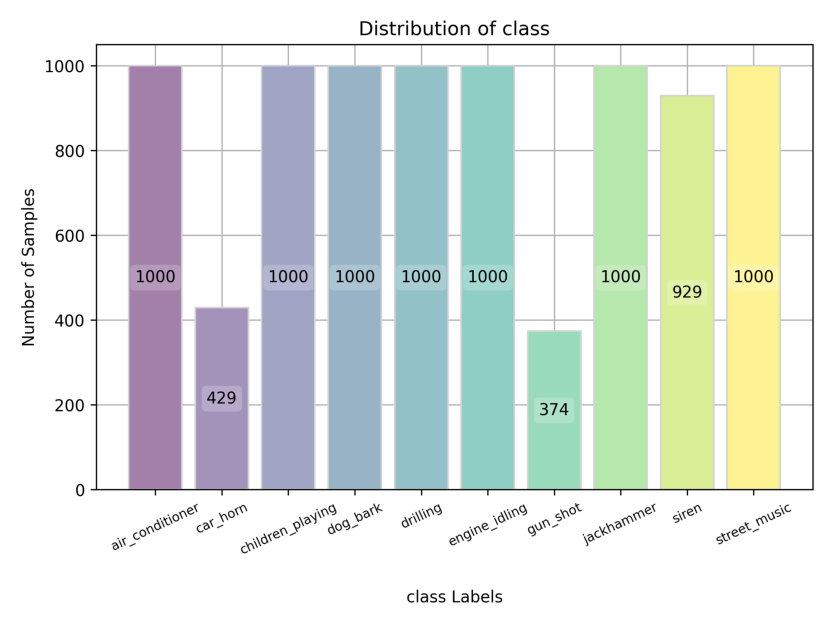

In [10]:
# Plot the distribution of the target class
plotFeatureDistribution(df=df, classFeature='class', pathsConfig=pathsConfig)

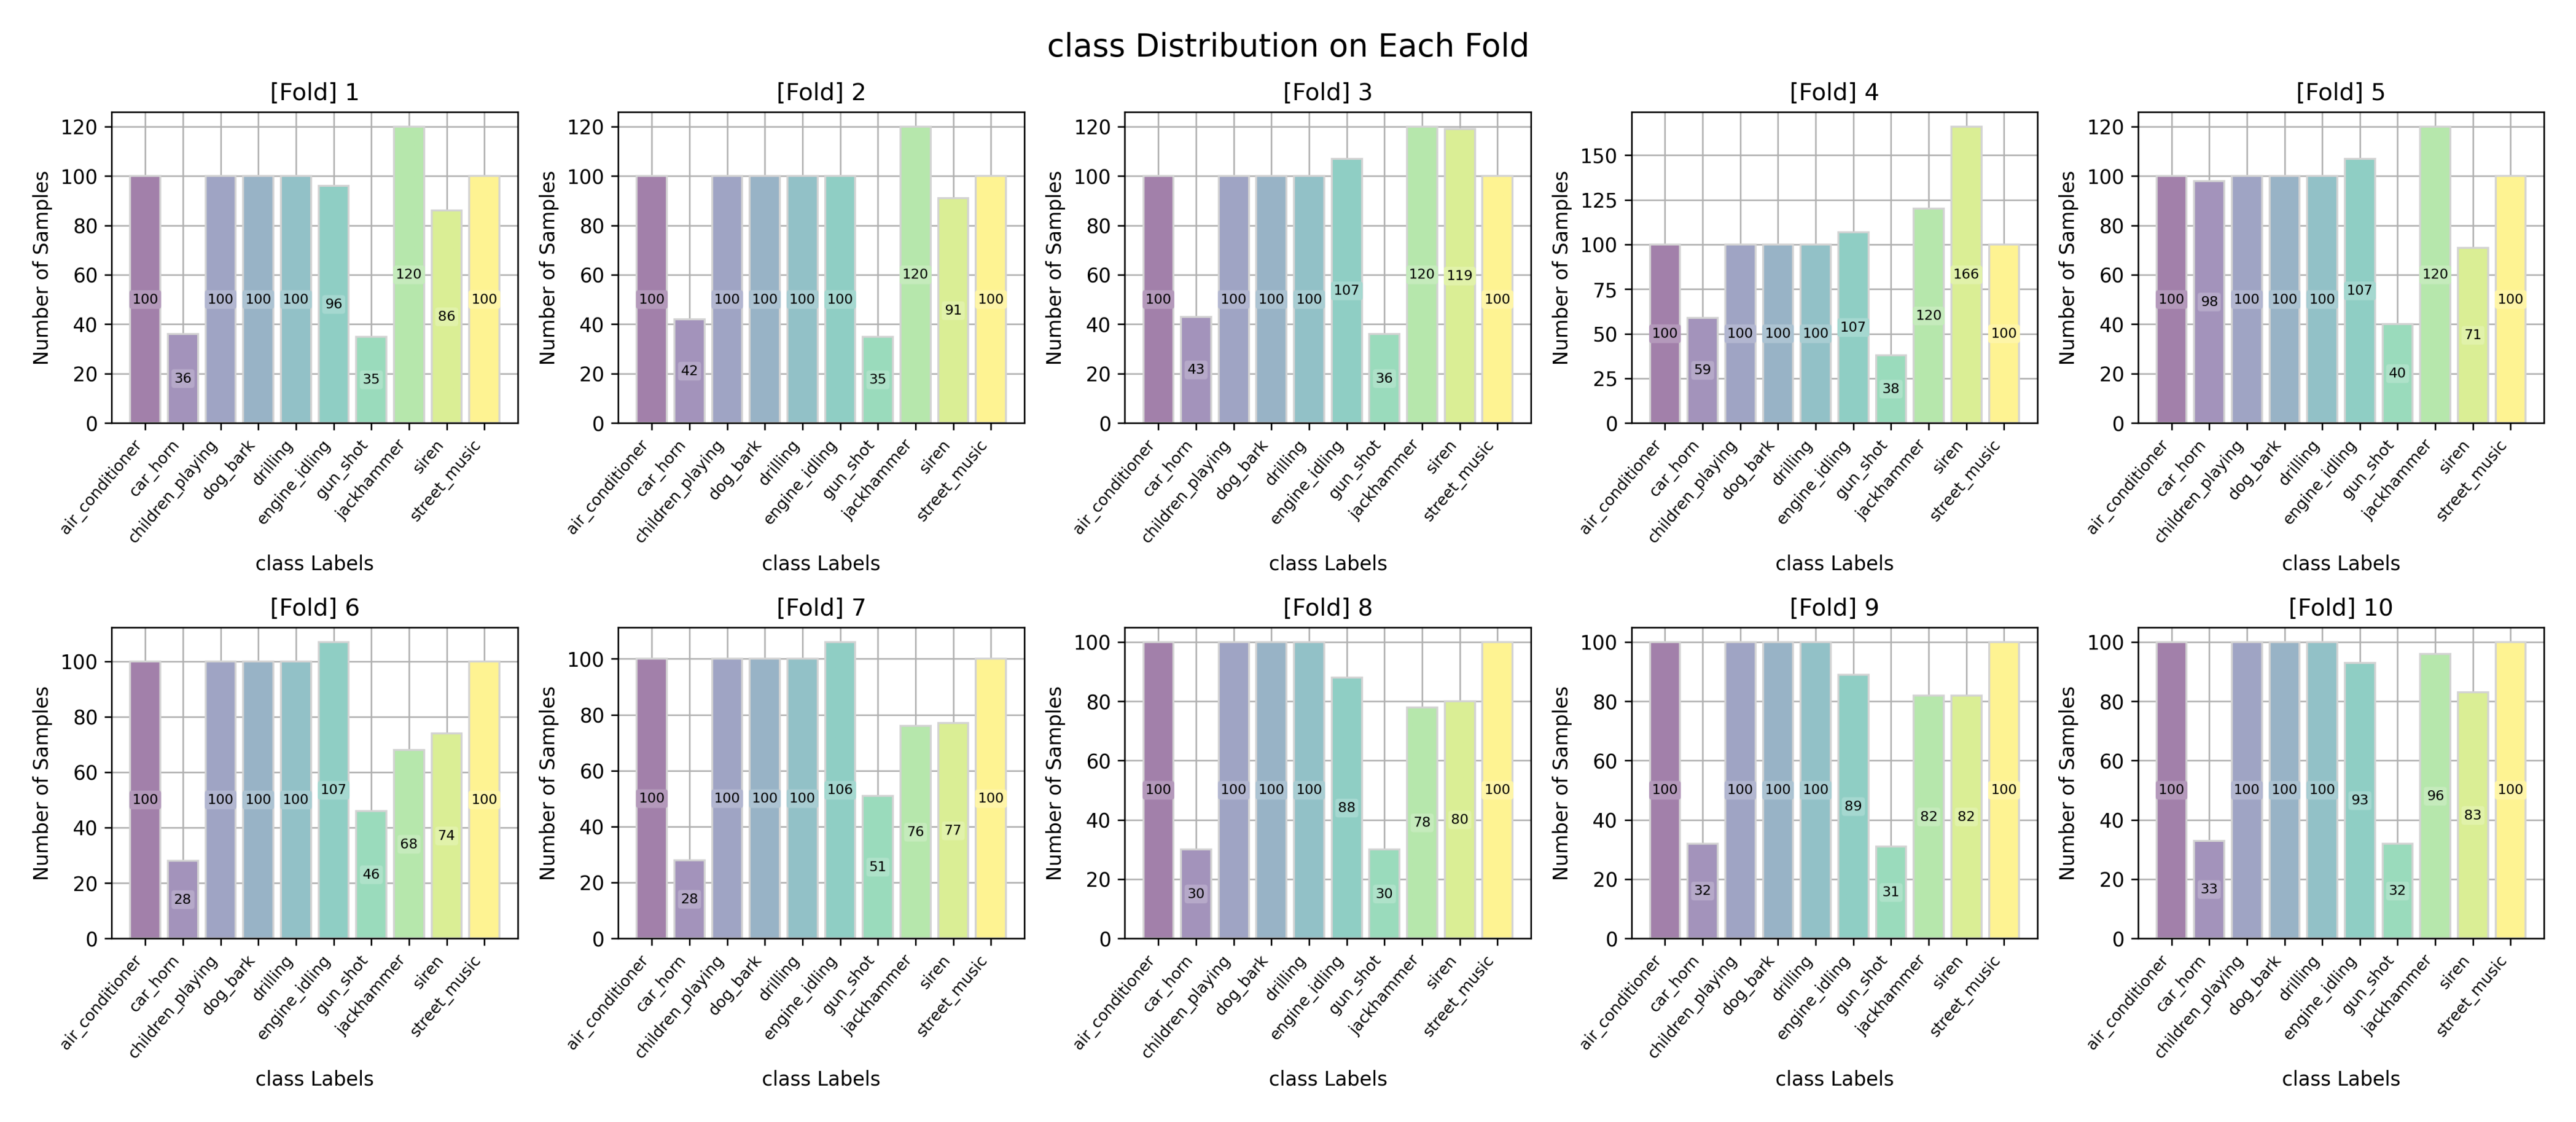

In [11]:
# Plot the class distribution per fold
plotFeatureDistributionByFold(df=df, classFeature='class', foldFeature='fold', pathsConfig=pathsConfig)

---
### Sound Features
---

To accurately analyze and extract features from audio samples, we first need to load them properly. Using the librosa library, we can handle each audio file from the dataset with careful consideration of duration, sample rate, and zero-padding.

The target length is calculated as the product of the DURATION (4 seconds, as specified in the dataset) and the TARGET_SAMPLE_RATE.

We opted to increase the sample rate from the default 22,050 Hz to 44,100 Hz to capture higher-quality details, given the variety of sounds in the dataset — ranging from complex audio like street music to simpler noises like car horns. 

Consequently, zero-padding will ensure that all audio samples remain with a consistent length, standardizing the dataset for more reliable feature extraction. Moreover, this size consistency is crucial when training deep learning models, since they require a uniform input size across all samples.

In [12]:
# Load a audio
audioData = loadAudio(df_audio=df, audioSliceName='100263-2-0-137.wav', audioDuration=config['DURATION'], targetSampleRate=config['SAMPLE_RATE'], usePadding=True)
audioData.shape

(176400,)

---
### 1-Dimensional Features
---

#### &rarr; Zero-Crossing Rate (ZCR)

``Description`` : ZCR measures how often the signal changes sign (crosses zero) in a frame.

This is a time-domain feature that is particularly useful for distinguishing between different types of noise or impulsive sounds, such as car horns or dog barks, which have different temporal behaviors.

In [13]:
zeroCrossingRate = libr.feature.zero_crossing_rate(y=audioData)
print(zeroCrossingRate.shape)
# zeroCrossingRate

(1, 345)


#### &rarr; Spectral Centroid

``Description`` : The spectral centroid is the "center of mass" of the spectrum, giving an indication of where the energy of the sound is concentrated.

It helps in distinguishing between sounds with different frequency content (e.g., high-pitched sirens vs. low-pitched engine noises).

In [14]:
spectralCentroid = libr.feature.spectral_centroid(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralCentroid.shape)
# spectralCentroid

(1, 345)


#### &rarr; Spectral Bandwidth

``Description`` : This measures the width of the spectrum (the difference between the lower and upper frequencies in a sound).

It helps distinguish sounds with wide frequency content (e.g., crowd noise) from those with narrow frequency content (e.g., beeps or alarms).

In [15]:
spectralBandwidth = libr.feature.spectral_bandwidth(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralBandwidth.shape)
# spectralCentroid

(1, 345)


#### &rarr; Spectral Flatness

``Description`` : Measures how noise-like or tonal a sound is by comparing the geometric and arithmetic means of the power spectrum.

Helps distinguish between tonal sounds (e.g., sirens, horns) and noise-like sounds (e.g., wind, traffic).

In [16]:
spectralFlatness = libr.feature.spectral_flatness(y=audioData)
print(spectralFlatness.shape)
# spectralFlatness

(1, 345)


#### &rarr; Spectral Roll-off

``Description`` : Spectral roll-off is the frequency below which a specified percentage (usually 85-90%) of the total spectral energy is contained.

It helps differentiate between high-frequency sounds (e.g., sharp noises like sirens or alarms) and low-frequency sounds (e.g., engine noise, rumbling).

In [17]:
spectralRolloff = libr.feature.spectral_rolloff(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralRolloff.shape)
# spectralRolloff

(1, 345)


#### &rarr; RMS Energy

``Description`` : The Root Mean Square (RMS) energy is a measure of the signal's energy over time.

It is useful to distinguish between quiet and loud sounds and can help classify sounds with varying intensity, such as traffic or construction noise.

In [18]:
rms = libr.feature.rms(y=audioData)
print(rms.shape)
# rms

(1, 345)


---
### 2-Dimensional Features
---

#### &rarr; Mel-Frequency Cepstral Coefficients (MFCC)

``Description`` : MFCCs represent the short-term power spectrum of an audio signal, emphasizing the perceptually relevant features for human hearing.

MFCCs are widely used in audio classification tasks, including speech recognition and environmental sound classification. They effectively capture the timbral texture of sounds, which is important for distinguishing different urban sound categories.

In [19]:
mfccs = libr.feature.mfcc(y=audioData, sr=config['SAMPLE_RATE'], n_mfcc=config['N_MFCC'])
print(mfccs.shape)
# mfccs

(13, 345)


#### &rarr; Chroma Features (Chroma STFT)

``Description`` : Chroma features represent the pitch class (e.g., C, C#, D, etc.) and are useful for identifying tonal and harmonic content in audio.

While chroma features are traditionally more useful for music, they can capture harmonic structure in urban sounds, especially those with tonal elements like sirens or honking.

In [20]:
chroma_stft = libr.feature.chroma_stft(y=audioData, n_chroma=config['N_CHROMA'], sr=config['SAMPLE_RATE'], n_fft=config['N_FFT'], hop_length=config['HOP_LENGTH'], win_length=config['WINDOW_LENGTH'])
print(chroma_stft.shape)
# chroma_stft

(12, 321)


#### &rarr; Mel Spectrogram

``Description`` : A Mel spectrogram is a representation of the signal's power across different frequencies, scaled to the Mel scale (which mimics human auditory perception).

It is particularly useful for capturing the overall energy and frequency distribution of urban sounds. It’s a more detailed version of MFCCs, emphasizing the full frequency range.

In [21]:
melSpectrogram = libr.feature.melspectrogram(y=audioData, sr=config['SAMPLE_RATE'])
print(melSpectrogram.shape)
# melSpectrogram

(128, 345)


#### &rarr; Spectral Contrast

``Description`` : Spectral contrast measures the difference between peaks and valleys in the sound spectrum.

Urban sounds tend to have diverse spectral profiles (e.g., the contrast between loud car horns and quieter ambient sounds), making spectral contrast useful for distinguishing between classes.

In [22]:
spectralContrast = libr.feature.spectral_contrast(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralContrast.shape)
# spectralContrast

(7, 345)


---

---
---
### PLOTS

[Text(0.5, 1.0, 'MFCC')]

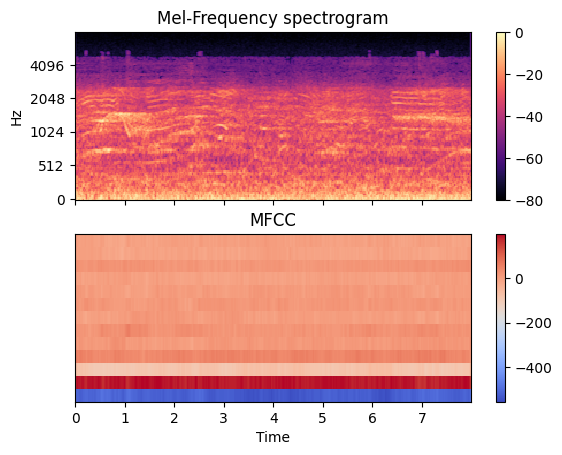

In [23]:
fig, ax = plt.subplots(nrows=2, sharex=True)
img = libr.display.specshow(libr.power_to_db(melSpectrogram, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel-Frequency spectrogram')
ax[0].label_outer()
img = libr.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

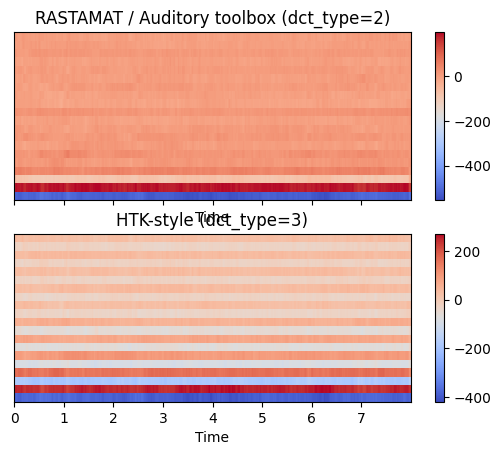

In [24]:
m_slaney = libr.feature.mfcc(y=audioData, sr=config['SAMPLE_RATE'], dct_type=2)
m_htk = libr.feature.mfcc(y=audioData, sr=config['SAMPLE_RATE'], dct_type=3)
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
img1 = libr.display.specshow(m_slaney, x_axis='time', ax=ax[0])
ax[0].set(title='RASTAMAT / Auditory toolbox (dct_type=2)')
fig.colorbar(img, ax=[ax[0]])
img2 = libr.display.specshow(m_htk, x_axis='time', ax=ax[1])
ax[1].set(title='HTK-style (dct_type=3)')
fig.colorbar(img2, ax=[ax[1]])

---
## Data Pre-Processing and Preparation
---

> PERFORM DATA PREPROCESSIGN AND PREPARATION

In [25]:
# CODE HERE

---
## Model Architecture Definition
---

> ADD MODEL ARCHITECTURE DEFINITION

In [26]:
# CODE HERE

---
## Training Strategies
---

> ADD TRAINING STRATEGIES

In [27]:
# CODE HERE

---
## Performance Evaluation
---
> ADD PERFORMANCE EVALUATION

In [28]:
# CODE HERE

<div align="center">

***
## Bibliographic References
***
</div>

1. AUTHOR (DATE OF PUBLICATION). __*ARTICLE TITLE*__. Available [here](__INSERT_LINK__)

LINKS:
- https://medium.com/@MuhyEddin/feature-extraction-is-one-of-the-most-important-steps-in-developing-any-machine-learning-or-deep-94cf33a5dd46
- https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504
- https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
- https://medium.com/@oluyaled/audio-classification-using-deep-learning-and-tensorflow-a-step-by-step-guide-5327467ee9ab
- https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab

---
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`
    - [Pedro Afonseca](https://github.com/PsuperX) &#8594; `up202205394@edu.fc.up.pt`